In [1]:
%matplotlib inline
from pjr import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

pjr.py complete


In [2]:
def findNiceContours_off(data,nlevs=None,noZero=None,sym=None,verbose=None):
    """Find Nice Contours
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
    nlevs = approximate number of contour levels to return (default 10)
    noZero = if defined supress the zero contour
    sym = if defined make the contour intervals symmetric about zero
    verbose = if defined, print out some info to help debug
    """
    if nlevs is None: nlevs = 8
    clevs = np.linspace(data.min(), data.max(), nlevs)
#    if nozero is None: nozero=0
#    if sym is None: sym=0
    zmax = data.max()
    zmin = data.min()
    if not verbose is None: print "zmin, zmax", zmin, zmax
    if zmax == zmin: 
        if (zmax != 0): 
          return np.array([0.9*zmax,zmax,1.1*zmax]);
        else:
          return np.array([-0.1,0.0, 0.1]);
    if not sym is None: 
        zcom = max(abs(zmin),abs(zmax));
        zmin = -zcom;
        zmax = +zcom;
        if not verbose is None: print "zmin, zmax in sym", zmin, zmax
    zrange = zmax/(zmin+1.e-20)
    okints = [0.1, 0.2, 0.5,1,2,5,10,20] # acceptable values for contour intervals
    okints = np.array(okints)
    zinc = (zmax-zmin)/nlevs;
    if not verbose is None: print "zinc", zinc
    pow = int(np.log10(zinc))
    if not verbose is None: print "pow", pow
    cints = okints*(10.**pow);
    if not verbose is None: print "cints", cints
    nlevsout = (zmax-zmin)/cints;
    if not verbose is None: print "nlevsout",nlevsout
#    np.where(V0 == V0.max())
    f1 = abs(nlevsout-nlevs)
    if not verbose is None: print "f1", f1
    f2 = np.where(f1 == f1.min());
    if not verbose is None: print "f2", f2
    nlevbest = int(f2[0])
    if not verbose is None: print "nlevbest, cintsbest",nlevbest, cints[nlevbest]
    if not verbose is None: print "f3", zmin/cints[nlevbest]
    zminout = int(zmin/cints[nlevbest])*cints[nlevbest];
    zmaxout = int(zmax/cints[nlevbest])*(cints[nlevbest]);
    ninc = int((zmaxout-zminout)/cints[nlevbest] + 1.00000001);
    if not verbose is None: print "ninc, zminout, zmaxout", ninc, zminout, zmaxout
    clevs = np.arange(zminout, zmaxout*1.001, cints[nlevbest]);
    if not noZero is None:    
        f4 = abs(clevs/max(abs(clevs)))
        if not verbose is None: print "f4", f4
        alist = np.where(f4 < 1.e-5);
        if not verbose is None: print "alist", alist
        if (np.size(alist) > 0): 
            zlist = np.where(clevs != 0)
            if not verbose is None: print "zlist", zlist
            if (np.size(zlist)> 0): 
                if not verbose is None: print"list of nonzero contour levels", zlist
                clevs = clevs[zlist];
    return clevs;
#clevs = findNiceContours(Txav)
clevs = findNiceContours(np.array([-9, 21.]))
print "fNC clevs", clevs

fNC clevs [-5.  0.  5. 10. 15. 20.]


In [3]:
def plotZMf_off(axesa, data, x, y, plotOpt=None, modelLevels=None, surfacePressure=None, clevs=None):
    """Create a zonal mean contour plot of one variable
    axesa = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
    x = 1d numpy array of latitude
    y = 1d numpy array of pressures (or pseudo pressure (like eta))
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'title': a title for the plot
      'ybot': if present, the pressure at the plot botnetom
      'ytop': if present, the pressure at the top
    modelLevels:  If present a small side panel will be drawn with lines for each model level
    surfacePressure: a list (dimension len(x)) of surface pressure values. If present, these will
        be used to mask out regions below the surface
    """
    # explanation of axes:
    #   ax1: primary coordinate system latitude vs. pressure (left ticks on y axis)
    #   ax2: twinned axes for altitude coordinates on right y axis
    #   axm: small side panel with shared y axis from ax2 for display of model levels
    # right y ticks and y label will be drawn on axr if modelLevels are given, else on ax2
    #   axr: pointer to "right axis", either ax2 or axm

    if plotOpt is None: plotOpt = {}
    labelFontSize = "small"
    # create figure and axes
    ax1 = axesa
    # scale data if requested
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # determine contour levels to be used; default: linear spacing, 12 levels
    clevs = plotOpt.get("clevs") 
    if clevs is None:
#       clevs = plotOpt.get('levels', np.linspace(data.min(), data.max(), 12))
        clevs = findNiceContours(data)
    print "data range",data.min(), data.max()
    print "clevs", clevs
    ## the next two lines work well, but I am going to modify them to do things differently
    ## map contour values to colors
    #norm=mpl.colors.BoundaryNorm(clevs, ncolors=256, clip=False)
    ## draw the (filled) contours
    #contour = ax1.contourf(x, y, pdata, levels=clevs, norm=norm) 
    # experimental
    # map contour values to colors
    norm=mpl.colors.BoundaryNorm(clevs, ncolors=256, clip=False)
    # draw the (filled) contours
    contour = ax1.contourf(x, y, pdata, levels=clevs, norm=norm) 
    # mask out surface pressure if given
    if not surfacePressure is None: 
        ax1.fill_between(x, surfacePressure, surfacePressure.max(), color="white")    
    # add a title
    title = plotOpt.get('title', 'Vertical cross section')
    ax1.set_title(title)
    # add colorbar
    # Note: use of the ticks keyword forces colorbar to draw all labels
    fmt = mpl.ticker.FormatStrFormatter("%g")
    cbar = fig.colorbar(contour, ax=ax1, orientation='horizontal', shrink=1.05, pad=0.2,
                        ticks=clevs, format=fmt)
    cbar.set_label(plotOpt.get('units', ''))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # set up y axes: log pressure labels on the left y axis, altitude labels
    # according to model levels on the right y axis
    ax1.set_ylabel("Pressure [hPa]")
    ax1.set_yscale('log')
#    print "y", y
    xmesh,ymesh = np.meshgrid(x, y)
    print "ymesh range", ymesh.min(), ymesh.max()
    ybotd = 10.*np.ceil(ymesh.max()/10.)
    ytopd = ymesh.min()
    print "ybot, ytop defaults", ybotd, ytopd
    ybot = plotOpt.get('ybot', ybotd)
    ytop = plotOpt.get('ytop', ytopd)
#    ybot = 1000.
#    ytop = 1.
    ax1.set_ylim(ybot, ytop) # avoid truncation of 1000 hPa
    subs = [1,2,5]
    if ybot/ytop < 20.:
        subs = [1,2,3,4,5,6,7,8,9]
    print "subs", subs
    ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    y1loc = mpl.ticker.LogLocator(base=10., subs=subs)
    ax1.yaxis.set_major_locator(y1loc)
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax1.yaxis.set_major_formatter(fmt)
    for t in ax1.get_yticklabels():
        t.set_fontsize(labelFontSize)
    # calculate altitudes from pressure values (use fixed scale height)
    z0 = 8.400    # scale height for pressure_to_altitude conversion [km]
    altitude = z0 * np.log(1000./ymesh)
#    altitude = z0 * np.log(1015.23/ymesh)
    # add second y axis for altitude scale 
    ax2 = ax1.twinx()
    # change values and font size of x labels
    ax1.set_xlabel('Latitude [degrees]')
    ax1.xaxis.labelpad = 0.05
    xloc = mpl.ticker.FixedLocator(np.arange(-90.,91.,30.))
    ax1.xaxis.set_major_locator(xloc)
    for t in ax1.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # draw horizontal lines to the right to indicate model levels
    if not modelLevels is None:
        pos = ax1.get_position()
        axm = fig.add_axes([pos.x1,pos.y0,0.02,pos.height], sharey=ax2)
        axm.set_xlim(0., 1.)
        axm.xaxis.set_visible(False)
        modelLev = axm.hlines(altitude, 0., 1., color='0.5')
        axr = axm     # specify y axis for right tick marks and labels
        # turn off tick labels of ax2
        for t in ax2.get_yticklabels():
            t.set_visible(False)
        label_xcoor = 4.7
    else:
        axr = ax2
        label_xcoor = 1.13
    axr.set_ylabel("Altitude [km]")
    axr.yaxis.set_label_coords(label_xcoor, 0.5)
    altsub = altitude[(ymesh >= ytop) & (ymesh <= ybot)]
#    altsub = altitude
#    axr.set_ylim(altitude.min(), altitude.max())
    print "pressure and altitude range", ybot, ytop, altsub.min(), altsub.max()
    axr.set_ylim(altsub.min(), altsub.max())
    yrloc = mpl.ticker.MaxNLocator(steps=[1,2,5,10])
    axr.yaxis.set_major_locator(yrloc)
    axr.yaxis.tick_right()
    for t in axr.yaxis.get_majorticklines():
        t.set_visible(False)
    for t in axr.get_yticklabels():
        t.set_fontsize(labelFontSize)


In [4]:
fname = "/Users/d3x345/Desktop/NetCDF_files/vd05_ANN_climo.nc"
g2 = cdms2.open(fname);
varlist = g2.listvariables();
dims = g2.listdimension();
print dims;
print "\n".join(s for s in varlist if 'Z' in s) # find vars that contain 'Z'
#print varlist;

T =  g2('T',squeeze=1)            # extract fields, remove dimensions length one
lat2 = g2['lat']
lon2 = g2['lon']
lev2 = g2['lev']
#print "T.info()", T.info()

Z3 = g2('Z3',squeeze=1)
#print "Z3.info",Z3.info()
print "Z3.range",Z3.min(),Z3.max()


Txav = cdutil.averager(T,axis="x")
print "Txav=", Txav.info()

U =  g2('U',squeeze=1)            # extract fields, remove dimensions length one
Uxav = cdutil.averager(U,axis="x")

# print "LANDFRAC2av=", cdutil.averager(LANDFRAC2,axis="xy",weights="weighted")


['chars', 'cosp_ht', 'cosp_htmisr', 'cosp_prs', 'cosp_scol', 'cosp_sr', 'cosp_sza', 'cosp_tau', 'cosp_tau_modis', 'ilev', 'lat', 'lev', 'lon', 'nbnd', 'slat', 'slon', 'time']
BCFREZDEP
ZM_CLUBB
Z3
BCFREZCNT
LINOZ_SZA
LINOZ_SSO3
DSTFREZDEP
LINOZ_DO3_PSC
ZT_CLUBB
DSTFREZCNT
LINOZ_O3CLIM
BCFREZIMM
DSTFREZIMM
LINOZ_O3COL
LINOZ_DO3
Z3.range -7.5360394 64933.23
Txav=*** Description of Slab variable_8 ***
id: variable_8
shape: (72, 192)
filename: 
missing_value: 1e+20
comments: 
grid_name: N/A
grid_type: N/A
time_statistic: 
long_name: Temperature
units: K
tileIndex: None
mdims: [9]
cell_methods: time: mean
No grid present.
** Dimension 1 **
   id: lev
   Designated a level axis.
   units:  hPa
   Length: 72
   First:  0.12382541305561677
   Last:   998.4964394917621
   Other axis attributes:
      realtopology: linear
      positive: down
      formula_terms: a: hyam b: hybm p0: P0 ps: PS
      long_name: hybrid level at midpoints (1000*(A+B))
      standard_name: atmosphere_hybrid_sigma_pre

/Users/d3x345/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


text goes here
$$
a = \sqrt b^c
$$

In [5]:
def plotZM(data, x, y, plotOpt=None, modelLevels=None, surfacePressure=None):
    """Create a zonal mean contour plot of one variable
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
    x = 1d numpy array of latitude
    y = 1d numpy array of pressures (or pseudo pressure (like eta))
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'levels': use list of values as contour intervals
      'title': a title for the plot
      'ybot': if present, the pressure at the plot bottom
      'ytop': if present, the pressure at the top
    modelLevels:  If present a small side panel will be drawn with lines for each model level
    surfacePressure: a list (dimension len(x)) of surface pressure values. If present, these will
        be used to mask out regions below the surface
    """
    # explanation of axes:
    #   ax1: primary coordinate system latitude vs. pressure (left ticks on y axis)
    #   ax2: twinned axes for altitude coordinates on right y axis
    #   axm: small side panel with shared y axis from ax2 for display of model levels
    # right y ticks and y label will be drawn on axr if modelLevels are given, else on ax2
    #   axr: pointer to "right axis", either ax2 or axm

    if plotOpt is None: plotOpt = {}
    labelFontSize = "small"
    # create figure and axes
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # scale data if requested
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # determine contour levels to be used; default: linear spacing, 12 levels
    clevs = plotOpt.get('levels', np.linspace(data.min(), data.max(), 12))
    clevs = findNiceContours(data)
    print "data range", data.min(), data.max()
    print "clevs", clevs
    # map contour values to colors
    norm=mpl.colors.BoundaryNorm(clevs, ncolors=256, clip=False)
    # draw the (filled) contours
    contour = ax1.contourf(x, y, pdata, levels=clevs, norm=norm) 
    # mask out surface pressure if given
    if not surfacePressure is None: 
        ax1.fill_between(x, surfacePressure, surfacePressure.max(), color="white")    
    # add a title
    title = plotOpt.get('title', 'Vertical cross section')
    ax1.set_title(title)
    # add colorbar
    # Note: use of the ticks keyword forces colorbar to draw all labels
    fmt = mpl.ticker.FormatStrFormatter("%g")
    cbar = fig.colorbar(contour, ax=ax1, orientation='horizontal', shrink=0.8,
                        ticks=clevs, format=fmt)
    cbar.set_label(plotOpt.get('units', ''))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # set up y axes: log pressure labels on the left y axis, altitude labels
    # according to model levels on the right y axis
    ax1.set_ylabel("Pressure [hPa]")
    ax1.set_yscale('log')
#    print "y", y
    xmesh,ymesh = np.meshgrid(x, y)
    print "ymesh range", ymesh.min(), ymesh.max()
    ybotd = 10.*np.ceil(ymesh.max()/10.)
    ytopd = ymesh.min()
    print "ybot, ytop defaults", ybotd, ytopd
    ybot = plotOpt.get('ybot', ybotd)
    ytop = plotOpt.get('ytop', ytopd)
#    ybot = 1000.
#    ytop = 1.
    ax1.set_ylim(ybot, ytop) # avoid truncation of 1000 hPa
    subs = [1,2,5]
    if ybot/ytop < 20.:
        subs = [1,2,3,4,5,6,7,8,9]
    print "subs", subs
    ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    y1loc = mpl.ticker.LogLocator(base=10., subs=subs)
    ax1.yaxis.set_major_locator(y1loc)
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax1.yaxis.set_major_formatter(fmt)
    for t in ax1.get_yticklabels():
        t.set_fontsize(labelFontSize)
    # calculate altitudes from pressure values (use fixed scale height)
    z0 = 8.400    # scale height for pressure_to_altitude conversion [km]
    altitude = z0 * np.log(1000./ymesh)
#    altitude = z0 * np.log(1015.23/ymesh)
    # add second y axis for altitude scale 
    ax2 = ax1.twinx()
    # change values and font size of x labels
    ax1.set_xlabel('Latitude [degrees]')
    xloc = mpl.ticker.FixedLocator(np.arange(-90.,91.,30.))
    ax1.xaxis.set_major_locator(xloc)
    for t in ax1.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # draw horizontal lines to the right to indicate model levels
    if not modelLevels is None:
        pos = ax1.get_position()
        axm = fig.add_axes([pos.x1,pos.y0,0.02,pos.height], sharey=ax2)
        axm.set_xlim(0., 1.)
        axm.xaxis.set_visible(False)
        modelLev = axm.hlines(altitude, 0., 1., color='0.5')
        axr = axm     # specify y axis for right tick marks and labels
        # turn off tick labels of ax2
        for t in ax2.get_yticklabels():
            t.set_visible(False)
        label_xcoor = 4.7
    else:
        axr = ax2
        label_xcoor = 1.09
    axr.set_ylabel("Altitude [km]")
    axr.yaxis.set_label_coords(label_xcoor, 0.5)
    altsub = altitude[(ymesh >= ytop) & (ymesh <= ybot)]
#    altsub = altitude
#    axr.set_ylim(altitude.min(), altitude.max())
    print "pressure and altitude range", ybot, ytop, altsub.min(), altsub.max()
    axr.set_ylim(altsub.min(), altsub.max())
    yrloc = mpl.ticker.MaxNLocator(steps=[1,2,5,10])
    axr.yaxis.set_major_locator(yrloc)
    axr.yaxis.tick_right()
    for t in axr.yaxis.get_majorticklines():
        t.set_visible(False)
    for t in axr.get_yticklabels():
        t.set_fontsize(labelFontSize)
    # show plot
    plt.show()
plotOpt = {'levels':np.arange(170.,330.,10.),'units':'K','title':'Temperature'} #,
#         'ybot':800.,'ytop':500.}
plotOpt = {}
plotZM_V0(Uxav, lat2, lev2, plotOpt)

NameError: name 'plotZM_V0' is not defined

data range 192.9576998816597 299.56690947214753
clevs [190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290.]
ymesh range 0.12382541305561677 998.4964394917621
ybot, ytop defaults 1000.0 0.12382541305561677
subs [1, 2, 5]
pressure and altitude range 1000.0 0.12382541305561677 0.012639412713045764 75.57175872703017


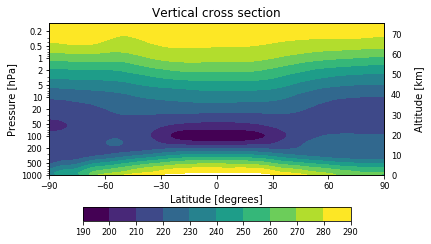

In [6]:
plotZM(Txav, lat2, lev2)

TypeError: plotZMf() got multiple values for keyword argument 'plotOpt'

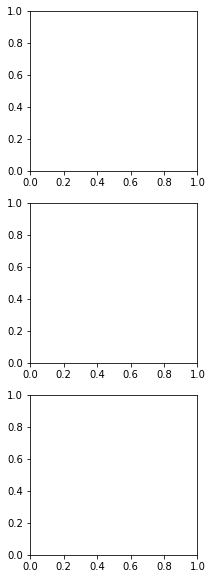

In [7]:

fig = plt.figure(figsize=(3., 10.))
plt.tight_layout(pad=0.05, w_pad=0.0, h_pad=0.1)
axest = fig.add_subplot(311)
axesm = fig.add_subplot(312)
axesb = fig.add_subplot(313)
plotOpt = {'levels':np.arange(170.,330.,10.),'units':'K','title':'Temperature'} #,
#         'ybot':800.,'ytop':500.}
plotOpt = {}
Dxav = Txav-Uxav-20
#plotZMf(axest, Txav, lat2, lev2, plotOpt={'title':'Temperature','clevs':findNiceContours(Txav)})
plotZMf(axest, Txav, lat2, lev2, plotOpt={'title':'Temperature'})
plotZMf(axesm, Uxav, lat2, lev2, plotOpt)
plotZMf(axesb, Dxav, lat2, lev2, plotOpt)

# show plot
plt.show()

In [ ]:
V2N = g2('PRECC',squeeze=1,lat=(0.,90.),lon=(220.,360.))*conv            # extract fields, remove dimensions length one
V2NA = cdutil.averager(V2N,axis="xy",weights="weighted")
#print "V2NA.info()", V2N.info(), V2N.shape;
#print "V2NA", V2NA
print "axes", V2N.getAxisList()
V2NS = V2N[:]  # produce a non-transient variable
#print "V2NS info", V2NS.info()
lat = V2NS.getAxis(0)
#print "lat", lat
lon = V2NS.getAxis(1)
#print "lon", lon
#help(V2NA)
plt.figure(figsize=(16, 4))
#fig, ax = plt.subplots()
plt.subplot(121)
plt.title("land fraction")
cs = plt.contourf(lon, lat, V2NS)
# add colorbar.
cbar = plt.colorbar(cs)
cbar.set_label('test')
print "LF2a_av=", cdutil.averager(V2NS,axis="xy",weights="weighted")
plt.show()

In [ ]:
plt.figure(figsize=(16, 4))
#fig, ax = plt.subplots()
plt.subplot(121)
plt.title("land fraction")
cs = plt.contourf(lon2, lat2, LANDFRAC2)
# add colorbar.
cbar = plt.colorbar(cs)
cbar.set_label('land(Fraction)')
print "LF2a_av=", cdutil.averager(LANDFRAC2,axis="xy",weights="weighted")
plt.show()

In [ ]:
#LANDFRAC.info()
#print "LANDFRAC2 =", cdutil.averager(LANDFRAC2,axis="xy",weights="weighted")
#print "masked LANDFRAC2 =", cdutil.averager(LFM,axis="xy",weights="weighted")
#print "dir(LF)", dir(LANDFRAC)
#print "xx", LANDFRAC2.info()
llist = (LANDFRAC2[:] < 0.5)
print "llist",llist[0,0],llist[-1,-1] # print out a few values which should be near NP and SP
#print "land zero", llist.shape
DVM = LANDFRAC2
DVM.mask = llist # add a mask for land points
print "longname",DVM.long_name
plt.figure(figsize=(16, 4))
#fig, ax = plt.subplots()
plt.subplot(121)
gavg = cdutil.averager(DVM,axis="xy",weights="weighted")
#titl = "{0:s} (model-obs) = {1:f}".format("DVM",gavg)
titl = "%s = %.2f"%("DVM", gavg)
print titl
plt.title(titl)
clevs =  np.arange(-60.,70., 10).tolist()
print clevs
cs = plt.contourf(lon2, lat2, DVM, clevs)
# add colorbar.
cbar = plt.colorbar(cs)
plt.show()
#print "masked DV =", cdutil.averager(DVM,axis="xy",weights="weighted")



In [ ]:
# example from http://matplotlib.org/basemap/users/examples.html

date = datetime(2007,12,15,0) # date to plot.
# open dataset.
#dataset = \
#Dataset('http://www.ncdc.noaa.gov/thredds/dodsC/OISST-V2-AVHRR_agg')
#timevar = dataset.variables['time']
#timeindex = date2index(date,timevar) # find time index for desired date.
# read sst.  Will automatically create a masked array using
# missing_value variable attribute. 'squeeze out' singleton dimensions.
#sst = dataset.variables['sst'][timeindex,:].squeeze()
# read ice.
#ice = dataset.variables['ice'][timeindex,:].squeeze()

lons, lats = np.meshgrid(lon2,lat2)
print lons.shape
# create figure, axes instances.
fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
# create Basemap instance.
# coastlines not used, so resolution set to None to skip
# continent processing (this speeds things up a bit)
m = Basemap(projection='kav7',lon_0=0,resolution=None)
# draw line around map projection limb.
# color background of map projection region.
# missing values over land will show up this color.
m.drawmapboundary(fill_color='0.3')
# plot sst, then ice with pcolor
# im1 = m.pcolormesh(lons,lats,DVM,shading='flat',cmap=plt.cm.jet,latlon=True)
# cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
# draw parallels and meridians, but don't bother labelling them.
# contour data over the map.
tlevs = [0.,0.1,0.2,0.5,1]
cs = m.contourf(lons,lats,DVM,tlevs,latlon=True)
#cs = m.contourf(lons,lats,DVM,10,latlon=True)
plt.title('contour lines over filled continent background')
m.drawparallels(np.arange(-90.,99.,30.))
m.drawmeridians(np.arange(-180.,180.,60.))
# add colorbar
cb = m.colorbar(cs,"bottom", size="5%", pad="2%")
# add a title.
ax.set_title('DVM %s'% DVM.long_name)
plt.show()
